<a href="https://colab.research.google.com/github/ffelicioni/CV---Histopathologic-Cancer-Detection/blob/main/practica8_computervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica para quemadxs!

Clasificador para identificar tejido con metástasis en escaneos hispatológicos de secciones de ganglios linfáticos.

## Modulos

In [1]:
# instalamos el paquete para descargar archivos
#!pip install wget

# montamos la unidad de Google Drive
from google.colab import drive
#drive.mount('/content/gdrive/')

# data folder
#from os import makedirs
import os, os.path
#datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/Computer Vision/'
#makedirs(datasets_folder, exist_ok=True)

In [2]:
#generales
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [4]:
!pip install opendatasets
import opendatasets as od

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
od.download("https://www.kaggle.com/competitions/histopathologic-cancer-detection/data/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: flaviafelicioni
Your Kaggle Key: ··········


100%|██████████| 6.31G/6.31G [02:32<00:00, 44.4MB/s]



Extracting archive ./histopathologic-cancer-detection/histopathologic-cancer-detection.zip to ./histopathologic-cancer-detection


## 1- Exploración

In [6]:
# pedimos los tamaños 
PATH='/content/histopathologic-cancer-detection/'
path_completo = PATH+'train/'
N=len([name for name in os.listdir(path_completo) if os.path.isfile(os.path.join(path_completo, name))])
print('histopathologic - Training + Val sets size: {}'.format(N))

path_completo = PATH+'test/'
N_test=len([name for name in os.listdir(path_completo) if os.path.isfile(os.path.join(path_completo, name))])
print('histopathologic - Test set size: {}'.format(N_test))

print('porcentaje test: {}'.format(N_test/(N_test+N)))

histopathologic - Training + Val sets size: 220025
histopathologic - Test set size: 57458
porcentaje test: 0.20706854113585338


In [7]:
print('porcentaje requerido para validation_set: {}'.format(0.1*(N_test+N)/N))

porcentaje requerido para validation_set: 0.12611430519259176


In [8]:
# y le pedimos al grupo de train el elemento 10
path_completo = PATH+'train/'

data_sample = os.listdir(path_completo)[10]
print(data_sample)

im = Image.open(path_completo+data_sample)
print(im)
#96*96*3 canales

56459f2753c510e11f2923a6d42f8597953458e0.tif
<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=96x96 at 0x7F97A3B81E90>


In [9]:
labels_df=pd.read_csv(PATH+'train_labels.csv')
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
test_set=pd.read_csv(PATH+'sample_submission.csv')
test_set.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


visualizo una de las imágenes

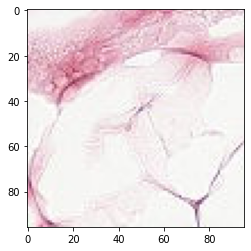

Label: [0 1]


In [11]:
# mostramos la imagen
plt.imshow(im)
plt.show()

# e imprimimos la etiqueta
print('Label: {}'.format(labels_df.label.unique()))

0    130908
1     89117
Name: label, dtype: int64


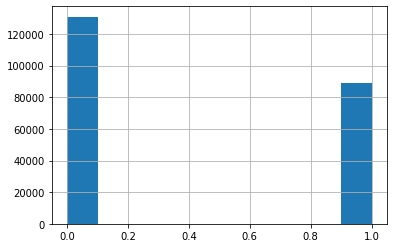

In [12]:
%matplotlib inline
labels_df['label'].hist();
print(labels_df['label'].value_counts()) #normal malignos

rango en las imágenes

In [13]:
# ahora la pasamos a tensor usando ToTensor()
to_tensor = transforms.ToTensor()
img_t = to_tensor(im)

# imprimimos el rango de intensidades original de la imagen
print('Intensity range: [{}, {}]'.format(np.min(im), np.max(im)))

print('New intensity range: [{}, {}]'.format(torch.min(img_t), torch.max(img_t)))

print('')

# imprimimos los tamaños antes de pasar a tensor
print(np.asarray(im).shape)
# y ahora
print(img_t.shape)

Intensity range: [44, 255]
New intensity range: [0.1725490242242813, 1.0]

(96, 96, 3)
torch.Size([3, 96, 96])


In [ ]:
#img_t[:,:,2] #blue

In [14]:
im = Image.open(PATH+'train/'+labels_df.id[0]+'.tif')
print(im)

<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=96x96 at 0x7F97ACC63E10>


## 2- Train - test

generar partición en train (70%), validación (10%) y test (20%)

**Nota**: en el conjunto de test ya hay un 20% de datos.
así que sólo separo el de train en train y val (val es 12.6%)

In [15]:
from sklearn.model_selection import train_test_split

X=labels_df
y=labels_df.label
train_set, valid_set= train_test_split(X, test_size=0.126, random_state=42,stratify=y)

Verificación de la proporción

In [16]:
print(train_set.label.value_counts())
print('proporcion:',77888/114413)
N_train=len(train_set.label)

0    114413
1     77888
Name: label, dtype: int64
proporcion: 0.6807618015435309


In [17]:
print(valid_set.label.value_counts())
print('proporcion:',11229/16495)
print('porcentaje del total:',(16495+11229)/(N+N_test))
N_val=len(valid_set.label)

0    16495
1    11229
Name: label, dtype: int64
proporcion: 0.6807517429524098
porcentaje del total: 0.09991242706760414


In [18]:
print('id:',train_set.id[0], 'label:',train_set.label[0])

id: f38a6374c348f90b587e046aac6079959adf3835 label: 0


In [ ]:
# ejemplo
#training_set = [tuple(x) for x in train_set.to_numpy()]
#print(training_set[0])

#validation_set = [tuple(x) for x in valid_set.to_numpy()]
#print(validation_set[0])

### Clase dataset

In [19]:
#fijar la semilla
torch.manual_seed(42)

In [20]:
#clase dataset

class histopDataset(torch.utils.data.dataset.Dataset):
  '''
  Clase para el dataset de histopatologic cancer dataset
  '''

  def __init__(self, partition):  
    '''
    Constructor de la clase. Podemos pasarle todos los parámetros que querramos,
    en este caso usamos:
    - partition: si es 'training', 'validation' o 'test'
    '''

    # usamos siempre el constructor de la clase madre primero, por las dudas que
    # inicialice cosas que nosotros no sepamos
    super(histopDataset, self).__init__()

    # hacemos un chequeo de que no entre cualquier cosa en vez de partition
    assert partition in ['training', 'validation','test'], 'partition has to be training or validation, not {}'.format(partition)
    
    # armamos las transformaciones que tenemos que aplicarle,
    # se usan las propuestas en pag 52, Avendi
      
    if (partition=='training'):
      transformations = transforms.Compose([#transforms.RandomHorizontalFlip(p=.5),
                                          #transforms.RandomVerticalFlip(p=.5),
                                          #transforms.RandomRotation(45),
                                          #transforms.RandomResizedCrop(96,scale=(.8,1.0),ratio=(1.0,1.0)),
                                          transforms.ToTensor()])               
    else: #para validacion y test
      transformations = transforms.Compose([transforms.ToTensor()])                                 


    # hacemos una lista de nombres para las clases
    self.class_names = ['normal', 'maligno']

    # filtramos los elementos que no nos sirven y creamos un atributo data donde
    # vamos a poner todos los datos que necesitamos
    if (partition=='training'):
      self.data = [tuple(x) for x in train_set.to_numpy()]
      self.path_completo=PATH+'train/'

    elif (partition=='validation'):
      self.data = [tuple(x) for x in valid_set.to_numpy()]
      self.path_completo=PATH+'train/'

    else:
      self.data = [tuple(x) for x in test_set.to_numpy()]
      self.path_completo=PATH+'test/'

    self.transform = transformations

  def __len__(self):
    '''
    Método que te devuelve la cantidad de elementos del dataset
    '''
    # simplemente devolvemos la longitud de la lista
    return len(self.data)
  

  def __getitem__(self, index):
    '''
    Método que te devuelve el elemento index del dataset
    '''
    # leemos la imagen y su etiqueta asociada
    name, label = self.data[index]
    img=Image.open(self.path_completo+name+'.tif')
    img = self.transform(img)
    # convertimos la etiqueta en un tensor de tipo long
    tensor_label = torch.zeros(1)
    tensor_label[0] = label
    label = tensor_label.long()
    # retornamos el par
    return (img, label)

### Modelo

In [21]:
print('dimension del vector de entrada para la fully conected:',3* 96* 96)

dimension del vector de entrada para la fully conected: 27648


In [22]:
class histopFullyConnectedNN(nn.Module):
  '''
  Clase que implementa una arquitectura fully connected de 2 capas para
  resolver el problema de clasificar imagenes
  '''

  def __init__(self):
    '''
    Constructor: crea la arquitectura
    '''

    # siempre llamamos al constructor de la clase madre primero
    super(histopFullyConnectedNN, self).__init__()
    # número de salidas del modelo (probabilidades de ser normal o maligno)
    n_out = 2

    self.model = nn.Sequential(
        # una capa fully connected
        nn.Linear(27648,  # cantidad de features en la entrada: 96 x 96 x 3 colores
                  64),     # tamaño de la hidden layer
        nn.ReLU(), # función de activación
        
        nn.Linear(64, # cantidad de features en la entrada: 96 x 96 x 3 colores
                  32),  # tamaño de la hidden layer
        nn.ReLU(), 
        
        # otra capa fully connected
        nn.Linear(32, # tamaño de la hidden layer
                  n_out) # cantidad de clases en la salida,
        #nn.Softmax(dim=1) #no se usa mas la softmax ya que viene dentro de final activation
    )
    # agregamos la función de activación como un atributo
    self.final_activation = nn.Softmax(dim=1)

  def forward(self, inputs):
    '''
    Método que implementa el forward pass
    '''

    return self.model(inputs)

  def predict(self, inputs):
    '''
    Método que usaremos de aquí en más cuando queremos predecir resultados
    '''
    # devolvemos el resultado de llamar al modelo y aplicarle la función de activación
    return self.final_activation(self.model(inputs))

### Prueba de lectura y predict, sin haber entrenado el modelo

torch.Size([3, 96, 96])
tensor([0])


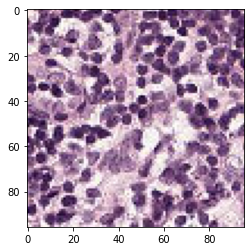

tensor([[0.1423, 0.0397]], grad_fn=<AddmmBackward0>)
tensor([0])


In [23]:
# creamos un modelo
fc_model = histopFullyConnectedNN()

# creamos una instancia de nuestro dataset
histop_training_set = histopDataset('training')
# sacamos una imagen
img, label = histop_training_set[1]
print(img.size())
print(label)
# la mostramos
plt.imshow(img.permute(1,2,0))
plt.show()

# ahora reformateamos la imagen para que la red la pueda usar
# (necesitamos que sea un vector de 3072 intensidades, y que tenga una
# dimensión extra al principio para simular un batch)
img_as_batch = img.view(-1).unsqueeze(0)

# alimentamos al modelo
out = fc_model(img_as_batch)
# imprimimos la salida (las probabilidades)
print(out)
# e imprimimos también la clase (que será la de mayor probabilidad)
_, index = torch.max(out, dim=1)
print(index)

In [24]:
# evaluamos la salida de este nuevo modelo sin usar predict
raw_out = fc_model(img_as_batch)
# evaluamos la salida de este nuevo modelo usando el método predict
softmax_out = fc_model.predict(img_as_batch)
# imprimimos los valores
print('Raw output: {}'.format(raw_out))
print('salida del modelo: {}'.format(softmax_out))

Raw output: tensor([[0.1423, 0.0397]], grad_fn=<AddmmBackward0>)
salida del modelo: tensor([[0.5256, 0.4744]], grad_fn=<SoftmaxBackward0>)


In [25]:
# inicializamos la función de pérdida
loss_fn = nn.CrossEntropyLoss()
# la evaluamos sobre la salida de la red
print(loss_fn(raw_out, label))

tensor(0.6431, grad_fn=<NllLossBackward0>)


## 3 -Entrenamiento

In [26]:
histop_training_set=histopDataset('training')
training_loader = DataLoader(histop_training_set, batch_size=64, shuffle=True)

In [27]:
histop_validation_set=histopDataset('validation')
validation_loader = DataLoader(histop_validation_set, batch_size=64, shuffle=False)

In [28]:
histop_test_set=histopDataset('test')
test_loader = DataLoader(histop_test_set, batch_size=64, shuffle=False)

In [ ]:
#ejemplo de train_dataloader
#for x, y in test_loader:
  #print(x)
  #print(y.shape)
#  break

### función de entrenamiento

In [29]:
# iteramos tantas épocas como hayamos dicho
def entrenamiento(model,n_epochs, learning_rate, optimizer, training_loader, validation_loader,loss_fn):
  # -----------------
  # TRAINING LOOP
  # -----------------

  # inicializamos listas para guardar los valores de loss function de entrenamiento
  # y validación, además del accuracy sobre datos de validación
  per_epoch_training_loss_values = np.zeros(n_epochs)
  per_epoch_validation_loss_values = np.zeros(n_epochs)
  per_epoch_validation_accuracy_values = np.zeros(n_epochs)
  
  for epoch in range(n_epochs):

    # tenemos que poner el modelo en modo entrenamiento
    model.train()

    # inicializamos una lista para ir guardando los valores de loss por batch
    training_loss_values = np.zeros(len(training_loader))
  
    # iteramos por cada batch
    i=0
    for imgs, labels in training_loader:

      # acomodamos las imágenes al formato de entrada de la red
      batch_size = imgs.shape[0]
      imgs = imgs.view(batch_size, -1)
      # pasamos imágenes y labels al dispositivo donde estemos corriendo
      imgs = imgs.to(device)
      labels = labels.view(-1).to(device)
      # obtenemos la respuesta del modelo
      outputs = model(imgs)
      # calculamos la loss
      loss = loss_fn(outputs, labels)
    
      # mandamos a 0 los gradientes
      optimizer.zero_grad()
      # hacemos un backward pass
      loss.backward()
      # y un paso del optimizador para actualizar los parámetros
      optimizer.step() 
    
      # registramos el valor de la loss
      training_loss_values[i]=float(loss.cpu())
      i=i+1

      # VALIDACIÓN
      # tenemos que poner el modelo en modo evaluación
      model.eval()

      # inicializamos una lista para guardar los valores de loss por batch en los 
      # datos de validación
      validation_loss_values = np.zeros(len(validation_loader))
      # y dos variables para medir la cantidad de muestras totales y la cantidad de
      # aciertos
      total = 0
      correct = 0

    # no vamos a calcular gradientes
    with torch.no_grad():

    # iteramos por cada batch
      i=0
      for imgs, labels in validation_loader:

        # acomodamos las imágenes al formato de entrada de la red
        batch_size = imgs.shape[0]
        imgs = imgs.view(batch_size, -1)
        # pasamos imágenes y labels al dispositivo donde estemos corriendo
        imgs = imgs.to(device)
        labels = labels.view(-1).to(device)
        # obtenemos la respuesta del modelo
        outputs = model(imgs)
        # calculamos la loss
        loss = loss_fn(outputs, labels)
        # registramos el valor de la loss
        validation_loss_values[i]=float(loss.cpu())
        i=i+1

        # le aplicamos la activation function a las salidas para obtener scores
        probs = fc_model.final_activation(outputs)
        # obtenemos la predicción de la clase
        _, predicted = torch.max(probs.cpu(), dim=1)
        labels = labels.cpu()
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    # TERMINÓ LA ÉPOCA

    # actualizamos las estadísticas
    per_epoch_training_loss_values[epoch] = np.mean(training_loss_values)
    per_epoch_validation_loss_values[epoch] = np.mean(validation_loss_values)
    per_epoch_validation_accuracy_values[epoch] = correct / total

    if (epoch % 1) == 0:
      print('Epoch: {}'.format(epoch+1))
      print('- Training loss: {:.4f}'.format(per_epoch_training_loss_values[epoch]))
      print('- Validation loss: {:.4f}'.format(per_epoch_validation_loss_values[epoch]))
      print('- Validation accuracy: {:.4f}'.format(per_epoch_validation_accuracy_values[epoch]))

  return model, per_epoch_training_loss_values, per_epoch_validation_loss_values, per_epoch_validation_accuracy_values

Llamada a la función de entrenamiento

In [30]:
# mejor uso gpu
use_gpu = True
# elegimos si usamos cuda o cpu
if use_gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')


# creamos una instancia del modelo
fc_model = histopFullyConnectedNN()

# creamos la loss function
loss_fn = nn.CrossEntropyLoss()

# movemos todo lo que haga falta al dispositivo que hayamos elegido
fc_model = fc_model.to(device)
loss_fn = loss_fn.to(device)

# inicializamos un valor de learning rate
learning_rate = 1e-2
# creamos una instancia de un optimizador (por ejemplo, SGD),
# pasándole los parámetros de nuestro modelo y la learning rate que queremos usar
optimizer = optim.SGD(fc_model.parameters(), lr=learning_rate)

# determinamos el número de épocas por el que queremos entrenar
n_epochs = 16



fc_model, per_epoch_training_loss_values, per_epoch_validation_loss_values, per_epoch_validation_accuracy_values=entrenamiento(fc_model,n_epochs, learning_rate, optimizer, training_loader, validation_loader,loss_fn)

Epoch: 1
- Training loss: 0.6226
- Validation loss: 0.6366
- Validation accuracy: 0.5807
Epoch: 2
- Training loss: 0.5783
- Validation loss: 0.5587
- Validation accuracy: 0.7057
Epoch: 3
- Training loss: 0.5585
- Validation loss: 0.5624
- Validation accuracy: 0.7266
Epoch: 4
- Training loss: 0.5489
- Validation loss: 0.5549
- Validation accuracy: 0.7107
Epoch: 5
- Training loss: 0.5409
- Validation loss: 0.5281
- Validation accuracy: 0.7420
Epoch: 6
- Training loss: 0.5348
- Validation loss: 0.5229
- Validation accuracy: 0.7482
Epoch: 7
- Training loss: 0.5303
- Validation loss: 0.5928
- Validation accuracy: 0.7083
Epoch: 8
- Training loss: 0.5264
- Validation loss: 0.5434
- Validation accuracy: 0.7265
Epoch: 9
- Training loss: 0.5229
- Validation loss: 0.5251
- Validation accuracy: 0.7431
Epoch: 10
- Training loss: 0.5199
- Validation loss: 0.5960
- Validation accuracy: 0.7109
Epoch: 11
- Training loss: 0.5162
- Validation loss: 0.5367
- Validation accuracy: 0.7342
Epoch: 12
- Trainin

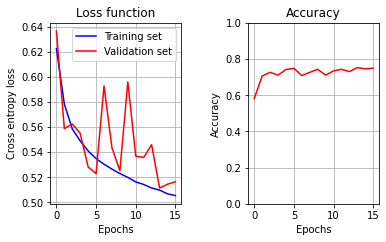

In [31]:
import matplotlib.pyplot as plt

# creamos plots para la loss y el accuracy
fig, axes = plt.subplots(1, 2)
# graficamos la evolución de la loss de entrenamiento y la de validación
axes[0].plot(per_epoch_training_loss_values, color='blue')
axes[0].plot(per_epoch_validation_loss_values, color='red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Cross entropy loss')
axes[0].grid(True)
axes[0].legend(['Training set', 'Validation set'])
axes[0].set_title('Loss function')
# graficamos la evolución del accuracy
axes[1].plot(per_epoch_validation_accuracy_values, color='red')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].set_title('Accuracy')
axes[1].set_ylim([0, 1.0])
fig.tight_layout(pad=3.0)

El modelo alcanza una accuracy de 74% aprox. que no es demasiado buena. La loss función va descendiendo en los datos de entreanamiento pero en los datos de validación a partir de la época 5 no sigue bajando, posiblemente porque esté overfitteando train.

## 4- Evaluación

#### Análisis de validación

In [32]:
# inicializamos el tamaño de batch
batch_size = 64

# ponemos el modelo en modo evaluación
fc_model.eval()

# inicializamos matrices y arreglos para guardar:
# - probabilidades
probabilities = np.zeros((N_val, 2))
# - predicciones
predictions = np.zeros(N_val)
# - labels
labels = np.zeros(N_val)

# sin calcular el gradiente...
with torch.no_grad():

  # inicializamos un contador de muestras
  num_samples = 0
  # iteramos por cada batch de test
  for i, (imgs, lbl) in enumerate(validation_loader):

    # acomodamos las imágenes al formato de entrada de la red
    num_outputs = imgs.shape[0]
    imgs = imgs.view(num_outputs, -1)
    # actualizamos la cantidad de muestras que vamos llevando
    num_samples = num_samples + num_outputs

    # obtenemos las predicciones
    probs = fc_model.predict(imgs.cuda())
    # pasamos la salida a CPU
    probs = probs.cpu()
    # y recuperamos la clase más probable
    _, predicted = torch.max(probs, dim=1)

    # colocamos las probabilidades, predicciones y etiquetas en los arreglos
    probabilities[i*batch_size : i*batch_size+num_outputs, :] = probs.numpy()
    predictions[i*batch_size : i*batch_size+num_outputs] = predicted.numpy()
    labels[i*batch_size : i*batch_size+num_outputs] = lbl.view(-1)

print("Cantidad de muestras procesadas = ", num_samples)
print("Probabilidades = ", probabilities.shape)
print("Predicciones = ", predictions.shape)
print("Etiquetas = ", labels.shape)

Cantidad de muestras procesadas =  27724
Probabilidades =  (27724, 2)
Predicciones =  (27724,)
Etiquetas =  (27724,)


In [33]:
from sklearn.metrics import accuracy_score, recall_score

def sensitivity(y_true, y_pred):
  # indicando que la clase positiva es 1, es exactamente igual a la sensitivity
  return recall_score(y_true, y_pred, pos_label=1)

def specificity(y_true, y_pred):
  # indicando que la clase positiva es 0, estamos "dándola vuelta" y haciendo
  # que nos calcule la especificidad
  return recall_score(y_true, y_pred, pos_label=0)

# calculamos accuracy, sensitivity y specificity
acc_ = accuracy_score(labels, predictions)
se_ = sensitivity(labels, predictions)
sp_ = specificity(labels, predictions)
# imprimimos por pantalla (recordar que 0 = avión y 1 = pájaro)
print("Accuracy = {:.4f}".format(acc_))
print("Sensitivity = {:.4f}".format(se_))
print("Specificity = {:.4f}".format(sp_))

Accuracy = 0.7493
Sensitivity = 0.7294
Specificity = 0.7628


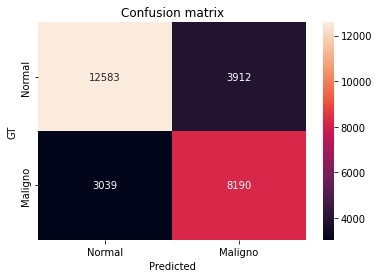

In [34]:
import seaborn as sn

# las predicciones en la columna Predicted
df = pd.DataFrame({'GT': labels, 'Predicted': predictions}, columns=['GT','Predicted'])

conf_mat = pd.crosstab(df['GT'], df['Predicted'], rownames=['GT'], colnames=['Predicted'], margins = False)

ax = plt.axes()
sn.heatmap(conf_mat, ax=ax, annot=True, fmt="d")
ax.set_title("Confusion matrix")
ax.set_xticklabels(["Normal", "Maligno"])
ax.set_yticklabels(["Normal", "Maligno"])
plt.show()

Curva ROC

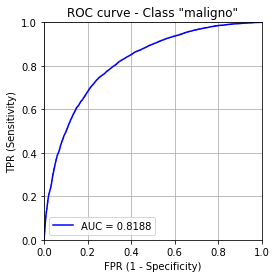

In [35]:
from sklearn.metrics import roc_curve, auc


def graficar_roc_curve(labels, probabilities, pos_label, color, class_names):

  # calculamos la curva ROC a partir de las probabilidades y para la clase
  # positiva dada
  fpr, tpr, thresholds = roc_curve(labels, probabilities, pos_label=pos_label)
  # calculamos el AUC
  auc_ = auc(fpr, tpr)

  # imprimimos la curva por pantalla
  plt.plot(fpr, tpr, color=color)                                       # mostramos la curva
  plt.gca().set_aspect('equal', adjustable='box')                       # siempre cuadrada!
  plt.xlabel("FPR (1 - Specificity)")                                   # siempre etiquetamos ejes
  plt.ylabel("TPR (Sensitivity)")
  plt.legend(["AUC = {:.4f}".format(auc_)])                              # mostramos el AUC
  plt.xlim([0.0, 1.0])                                                  # seteamos los límites de los
  plt.ylim([0.0, 1.0])                                                  #     ejes
  plt.grid(True)                                                        # mostramos una grilla
  plt.title("ROC curve - Class \"{}\"".format(class_names[pos_label]))  # titulamos la gráfica
  plt.show()

  return fpr, tpr, auc, thresholds



fpr_normal, tpr_normal, auc_normal, thresh = graficar_roc_curve(labels, 
                                                      probabilities[:,1], 
                                                      pos_label=1,
                                                      color="blue",
                                                      class_names=["normal", "maligno"])

#### Análisis de test

In [37]:
# inicializamos el tamaño de batch
batch_size = 64

# ponemos el modelo en modo evaluación
fc_model.eval()

# inicializamos matrices y arreglos para guardar:
# - probabilidades
probabilities_t = np.zeros((N_test, 2))
# - predicciones
predictions_t = np.zeros(N_test)
# - labels
labels_t = np.zeros(N_test)

# sin calcular el gradiente...
with torch.no_grad():

  # inicializamos un contador de muestras
  num_samples = 0
  # iteramos por cada batch de test
  for i, (imgs, lbl) in enumerate(test_loader):
    # acomodamos las imágenes al formato de entrada de la red
    num_outputs = imgs.shape[0]
    #print(imgs)
    imgs = imgs.view(num_outputs, -1)
    # actualizamos la cantidad de muestras que vamos llevando
    num_samples = num_samples + num_outputs

    # obtenemos las predicciones
    probs = fc_model.predict(imgs.cuda())
    # pasamos la salida a CPU
    probs = probs.cpu()
    # y recuperamos la clase más probable
    _, predicted = torch.max(probs, dim=1)

    # colocamos las probabilidades, predicciones y etiquetas en los arreglos
    probabilities_t[i*batch_size : i*batch_size+num_outputs, :] = probs.numpy()
    predictions_t[i*batch_size : i*batch_size+num_outputs] = predicted.numpy()
    #test_set.label.values[i*batch_size : i*batch_size+num_outputs]=np.array(range(0,num_outputs))+num_samples-num_outputs
    test_set.label.values[i*batch_size : i*batch_size+num_outputs]=predicted.numpy()
    

print("Cantidad de muestras procesadas = ", num_samples)
print("Probabilidades = ", probabilities_t.shape)
print("Predicciones = ", predictions_t.shape)

Cantidad de muestras procesadas =  57458
Probabilidades =  (57458, 2)
Predicciones =  (57458,)


In [38]:
test_set

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


In [39]:
predictions_t.sum()

24200.0

torch.Size([3, 96, 96])
tensor([0])


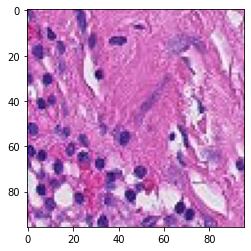

In [40]:
img, label = histop_test_set[63]
print(img.size())
print(label)
# la mostramos
plt.imshow(img.permute(1,2,0))
#print(img.permute(1,2,0))

Preparo submission (public score  0.7825, Private score: 0.7125)

In [41]:
test_set.to_csv('submission.csv', index=False)